In [5]:
import numpy as np
import pandas as pd
import os
import torch
from PIL import Image
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import cv2
import torch.nn as nn
import torch.nn.functional as F
#import albumentations as A
import torch.optim as optim 
from torch_lr_finder import *
from torch_lr_finder import LRFinder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from numpy import asarray
from fastai import *
from fastai.vision import *
#from fastai.vision.all import *
#from fastai.vision.data import ImageDataLoaders
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,DataLoader
import glob
from keras.models import load_model
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [6]:
classes = os.listdir("data_cropped")
print(classes)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data_cropped'

In [9]:
train_transformations = transforms.Compose([                                                                                 
    transforms.Resize((255,255)), #resize input images to 255,255
    transforms.ToTensor()
])

test_transformations = transforms.Compose([
    transforms.Resize((255,255)), #resize input images to 255,255
    transforms.ToTensor()
])

#applt the train and test transformations
training_dataset = ImageFolder('data_cropped', transform=train_transformations)  
testing_dataset= ImageFolder('specs_tes', transform=test_transformations)

In [10]:
print(training_dataset.classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [11]:
print(testing_dataset.classes)

NameError: name 'testing_dataset' is not defined

In [12]:
random_seed = 42
torch.manual_seed(random_seed);

val_size = int(0.2 * len(training_dataset))
train_size = len(training_dataset) - val_size

train_ds, val_ds = torch.utils.data.random_split(training_dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(43199, 10799)

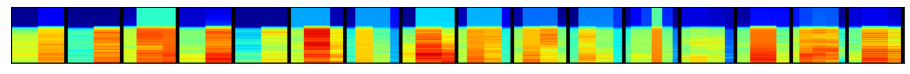

In [13]:
from torch.utils.data.dataloader import DataLoader

batch_size=16

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

#We can look at batches of images from the dataset using the `make_grid` method from `torchvision`.

from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_dl)

In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [15]:
device = get_default_device()
device

device(type='cpu')

In [16]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [17]:
import torch.nn as nn
import torch.nn.functional as F

In [18]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [19]:
@torch.no_grad() 
def evaluate(model, val_loader):
    model.eval() 
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train() 

        train_losses = [] 

        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item() 
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [20]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [21]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');


In [22]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return training_dataset.classes[preds[0].item()]

In [23]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer): 
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step() 
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [31]:
import torchvision.models as models

class Resnet34CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = models.resnet34(pretrained=True)
        
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 10)
         
    def forward(self, xb):
        xb= self.network(xb)
        return xb    
        
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False 
        for param in self.network.fc.parameters():
            param.require_grad = True 
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [29]:
!conda install -n base -c conda-forge jupyterlab_widgets
!conda install -n py36 -c conda-forge ipywidgets

^C



EnvironmentLocationNotFound: Not a conda environment: C:\Users\DSP\anaconda3\envs\py36



In [32]:

model_resnet34 = to_device(Resnet34CnnModel(), device)
model_resnet34


Resnet34CnnModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [33]:
evaluate(model_resnet34, val_dl)

{'val_loss': 2.364717960357666, 'val_acc': 0.16449087858200073}

In [34]:
model_resnet34.freeze()

epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [35]:
history6 = fit_one_cycle(epochs, max_lr, model_resnet34, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

Epoch [0], train_loss: 1.5090, val_loss: 1.9931, val_acc: 0.3314
Epoch [1], train_loss: 1.4481, val_loss: 1.6870, val_acc: 0.4183
Epoch [2], train_loss: 1.3778, val_loss: 1.4015, val_acc: 0.4742
Epoch [3], train_loss: 1.2894, val_loss: 1.3845, val_acc: 0.4889
Epoch [4], train_loss: 1.2247, val_loss: 1.2678, val_acc: 0.4981
Epoch [5], train_loss: 1.1408, val_loss: 1.1932, val_acc: 0.5462
Epoch [6], train_loss: 1.0428, val_loss: 0.9977, val_acc: 0.6189
Epoch [7], train_loss: 0.9708, val_loss: 0.9582, val_acc: 0.6268


In [36]:
model_resnet34.unfreeze()

epochs=8
history6 += fit_one_cycle(epochs, 0.001, model_resnet34, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

Epoch [0], train_loss: 0.9550, val_loss: 0.9556, val_acc: 0.6303
Epoch [1], train_loss: 0.9636, val_loss: 0.9951, val_acc: 0.6161
Epoch [2], train_loss: 0.9563, val_loss: 1.0063, val_acc: 0.6232
Epoch [3], train_loss: 0.9341, val_loss: 0.9820, val_acc: 0.6289
Epoch [4], train_loss: 0.9029, val_loss: 0.9165, val_acc: 0.6491
Epoch [5], train_loss: 0.8679, val_loss: 0.8921, val_acc: 0.6550
Epoch [6], train_loss: 0.8440, val_loss: 0.8814, val_acc: 0.6611
Epoch [7], train_loss: 0.8300, val_loss: 0.8812, val_acc: 0.6647


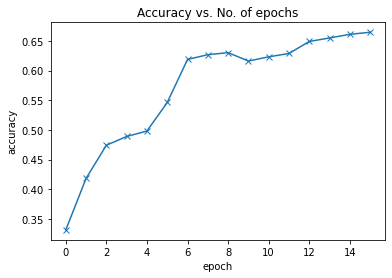

In [37]:
plot_accuracies(history6)

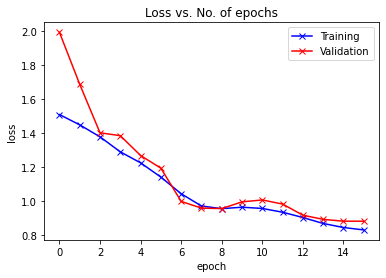

In [38]:
plot_losses(history6)

In [39]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

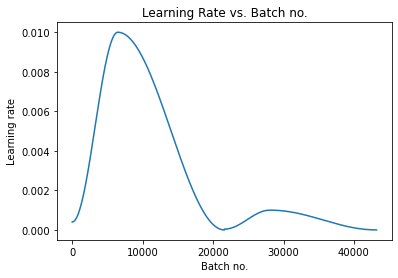

In [40]:
plot_lrs(history6)

In [ ]:
model_resnet34.unfreeze()

epochs=8
history6 += fit_one_cycle(epochs, 0.001, model_resnet34, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

In [ ]:
torch.save(model_resnet34, 'model_resnet34.pth')

In [ ]:
model = torch.load('model_resnet34.pth')
model.eval()

In [ ]:
model_resnet34.unfreeze()

epochs=10
history6 += fit_one_cycle(epochs, 0.001, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

In [ ]:
test_loader = DeviceDataLoader(DataLoader(testing_dataset, batch_size*2), device)
result = evaluate(model_resnet34, test_loader)
result

In [ ]:
path = "test_models/SER_emodb_test_rest_train_resnet34.pth" 
torch.save(model_resnet34.state_dict(), path) 

In [ ]:
model_resnet34 = to_device(Resnet34CnnModel(), device)
model_resnet34.load_state_dict(torch.load("test_models/SER_emodb_test_rest_train_resnet34.pth"))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(testing_dataset, batch_size*2), device)
evaluate(model_resnet34, test_loader)

In [ ]:
img, label = testing_dataset[76]
plt.imshow(img.permute(1, 2, 0))
print('Label:', training_dataset.classes[label], ', Predicted:', predict_image(img, model_resnet34))

In [ ]:
img, label = testing_dataset[130]
plt.imshow(img.permute(1, 2, 0))
print('Label:', training_dataset.classes[label], ', Predicted:', predict_image(img, model_resnet34))